# Intro to Machine Learning for Plant Sciences (ML4PS2025) - Deep Learning lab

## Introduction

Python has multiple high quality libraries for Deep Learning: **torch**, **tensorflow**, **keras**. 

These libraries are standard, documented, fairly easy to use and highly optimized. Within their ecosystem, they cover all components and aspects of the trade: data processing and loading, model design and training, optimization and parallelization, testing and evaluating.

Here are some libraries within this ecosystem that may be useful:
- **numpy** for handling data
- **pandas** for working with datasets
- **scipy** for optimization and maths problems
- **rasterio** for handling raster data (eg satellite imagery)
- **sklearn** for metrics and testing
- **wandb** (Weight and Biases) for hyperparameter tuning and keeping track of models trained
- **lightning** (on top of **pytorch**) for scalability and deployment with **pytorch**
... and so many more!




In [ ]:
import urllib
import matplotlib.pyplot as plt

import torch
import torchvision
from torch.utils.data import DataLoader
import torch.nn.functional as F
from torchvision import models
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, confusion_matrix

### Training a Computer Vision model

Simple classification framework


In [9]:
# Function definitions
def evaluate_model(model, loader):
    """Get predictions and true labels"""
    model.eval()
    all_preds = []
    all_labels = []
    with torch.no_grad():
        for inputs, labels in loader:
            outputs = model(inputs)
            _, preds = torch.max(outputs, 1)
            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())
    return all_labels, all_preds

In [10]:
# Normalization
temp_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor()
])

dataset_temp = OxfordIIITPet(root='./data', split='trainval', download=True, transform=temp_transform) # Temporary
temp_loader = DataLoader(dataset_temp, batch_size=32, shuffle=False) # Temporary

def compute_mean_std(loader):
    """Compute mean and std for normalization"""
    mean = 0.
    std = 0.
    total_images = 0

    for images, _ in loader:
        batch_samples = images.size(0)
        images = images.view(batch_samples, images.size(1), -1)
        mean += images.mean(2).sum(0)
        std += images.std(2).sum(0)
        total_images += batch_samples

    mean /= total_images
    std /= total_images
    return mean, std

mean, std = compute_mean_std(temp_loader)

transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist())
])

In [ ]:
# Train Test Validation split

# Load official datasets
trainval_dataset = OxfordIIITPet(root='./data', split='trainval', transform=transform)
test_dataset  = OxfordIIITPet(root='./data', split='test', transform=transform)
class_names = trainval_dataset.classes

# Create DataLoaders
train_dataset, val_dataset = train_test_split(trainval_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.104104..2.1378696].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.104104..2.190398].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-2.0693147..2.6806612].
Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers). Got range [-1.8779743..2.6806612].


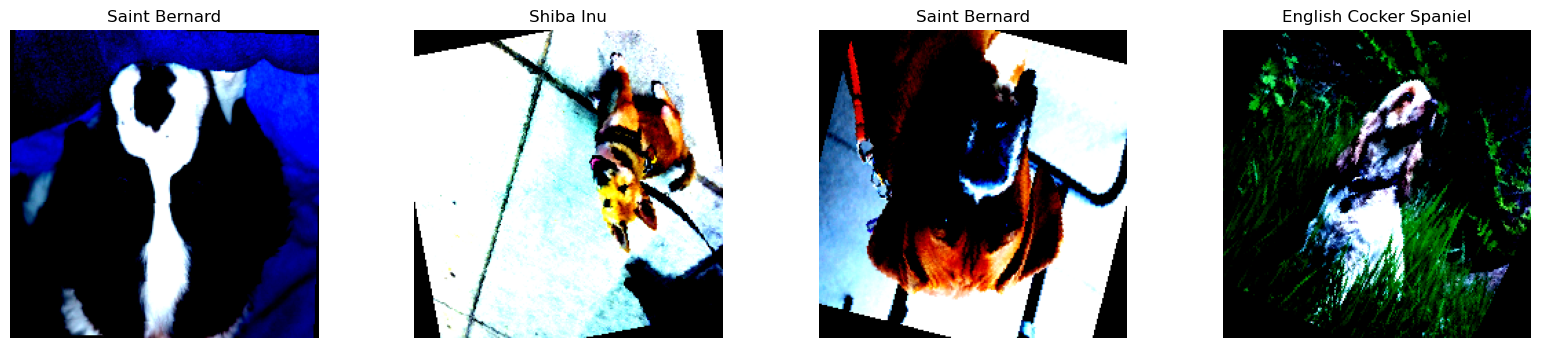

In [ ]:
# TODO Visualize some samples from the training set
# NOTE images are normalized to match standard input distribution expected giving them a weird look
images, labels = next(iter(train_loader))

fig, axes = plt.subplots(1, 4, figsize=(20, 4))
for idx, ax in enumerate(axes):
    img = images[idx].permute(1, 2, 0)  # C,H,W -> H,W,C
    ax.imshow(img)
    ax.set_title(class_names[labels[idx]])
    ax.axis('off')

plt.show()

2944 images (in train set) - 736 images (in val set) - 3669 images (in test set) 
37 classes


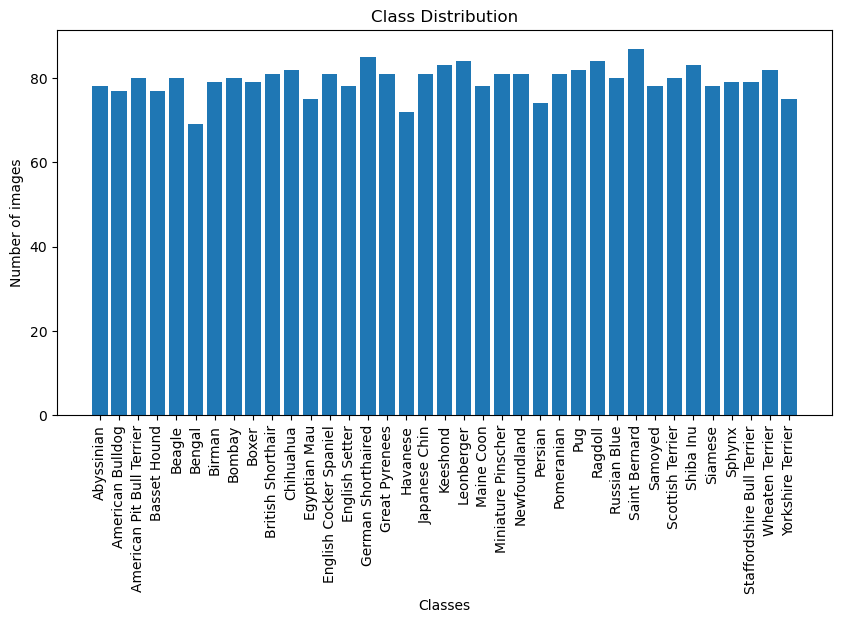

In [13]:
# Statistics
num_classes = len(class_names)
print(f"{len(train_dataset)} images (in train set) - {len(val_dataset)} images (in val set) - {len(test_dataset)} images (in test set) \n{num_classes} classes")

# Check dataset balance
def plot_class_distribution(dataset, class_names):
    class_counts = [0] * len(class_names)
    for _, label in dataset:
        class_counts[label] += 1

    plt.figure(figsize=(10, 5))
    plt.bar(class_names, class_counts)
    plt.xticks(rotation=90)
    plt.xlabel('Classes')
    plt.ylabel('Number of images')
    plt.title('Class Distribution')
    plt.show() 

plot_class_distribution(train_dataset, class_names)

 #### Training

In [ ]:
# Simple CNN model
class SimpleCNN(torch.nn.Module):
    def __init__(self, num_classes):
        super(SimpleCNN, self).__init__()
        self.conv1 = torch.nn.Conv2d(3, 16, kernel_size=3, stride=1, padding=1)
        self.conv2 = torch.nn.Conv2d(16, 32, kernel_size=3, padding=1)
        self.pool = torch.nn.MaxPool2d(kernel_size=2, stride=2, padding=0)
        self.fc1 = torch.nn.Linear(32 * 56 * 56, num_classes)

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)
        x = self.fc1(x)
        return x
    
model = SimpleCNN(num_classes=len(class_names)) # Model instantiation

# Display the architecture of the model
# TODO add or remove layers (conv2 - to be added/removed in __init__ and forward methods) and see the effect on performance
print(model)

SimpleCNN(
  (conv1): Conv2d(3, 16, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(16, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=100352, out_features=37, bias=True)
)


Epoch 1/10, Train Loss: 3.5257 - Val Loss: 3.4409
Epoch 2/10, Train Loss: 3.0435 - Val Loss: 3.3868
Epoch 3/10, Train Loss: 1.9965 - Val Loss: 4.0592
Epoch 4/10, Train Loss: 0.4500 - Val Loss: 5.2337
Epoch 5/10, Train Loss: 0.0763 - Val Loss: 5.8335
Epoch 6/10, Train Loss: 0.0341 - Val Loss: 6.3108
Epoch 7/10, Train Loss: 0.0038 - Val Loss: 6.3623
Epoch 8/10, Train Loss: 0.0013 - Val Loss: 6.5583
Epoch 9/10, Train Loss: 0.0010 - Val Loss: 6.7070
Epoch 10/10, Train Loss: 0.0008 - Val Loss: 6.8235
Training complete


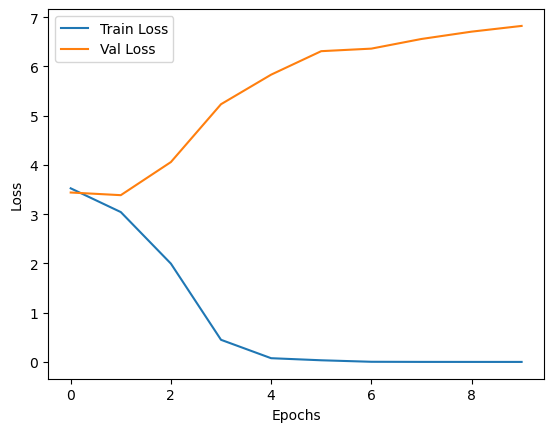

In [ ]:
# Training # TODO change the learning rate, number of epochs, batch size and see the effect on performance
# NOTE you should observe overfitting with validation loss not decreasing due to little data
criterion = torch.nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.SGD(model.parameters(), lr=0.001, momentum=0.9) # Optimizer
num_epochs = 10

train_losses, val_losses = list(), list()
for epoch in range(num_epochs):
    model.train() # training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()  # evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}')
print('Training complete')

# Plot training and validation loss
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

In [ ]:
# TODO think about overfitting: regularization, dropout, data augmentation, early stopping
# -> Here we implement data augmentation with random flips and rotations
# NOTE validation is augmented to be consistent with training

train_transform = transforms.Compose([
    transforms.Resize((224, 224)),
    transforms.ToTensor(),
    transforms.Normalize(mean.tolist(), std.tolist()),
    transforms.RandomHorizontalFlip(),
    transforms.RandomVerticalFlip(),
    transforms.RandomRotation(45),
])

# Load official datasets
trainval_dataset = OxfordIIITPet(root='./data', split='trainval', transform=train_transform)
test_dataset  = OxfordIIITPet(root='./data', split='test', transform=transform)
class_names = trainval_dataset.classes

# Create DataLoaders
train_dataset, val_dataset = train_test_split(trainval_dataset, test_size=0.2, random_state=42)
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=8, shuffle=False)

In [ ]:
# Training  # TODO change the learning rate, number of epochs, batch size and see the effect on performance
# NOTE augmentation (although a good idea) does not seem to fix overfitting here
criterion = torch.nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(model.parameters(), lr=1e-4, weight_decay=1e-4) # Optimizer
num_epochs = 10

train_losses, val_losses = list(), list()
for epoch in range(num_epochs):
    model.train() # training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    model.eval()  # evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}')
print('Training complete')

# Plot training and validation loss
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy on train set: 1.0
Accuracy on test set: 0.09948214772417552
Test f1-score: 0.09105531771907639


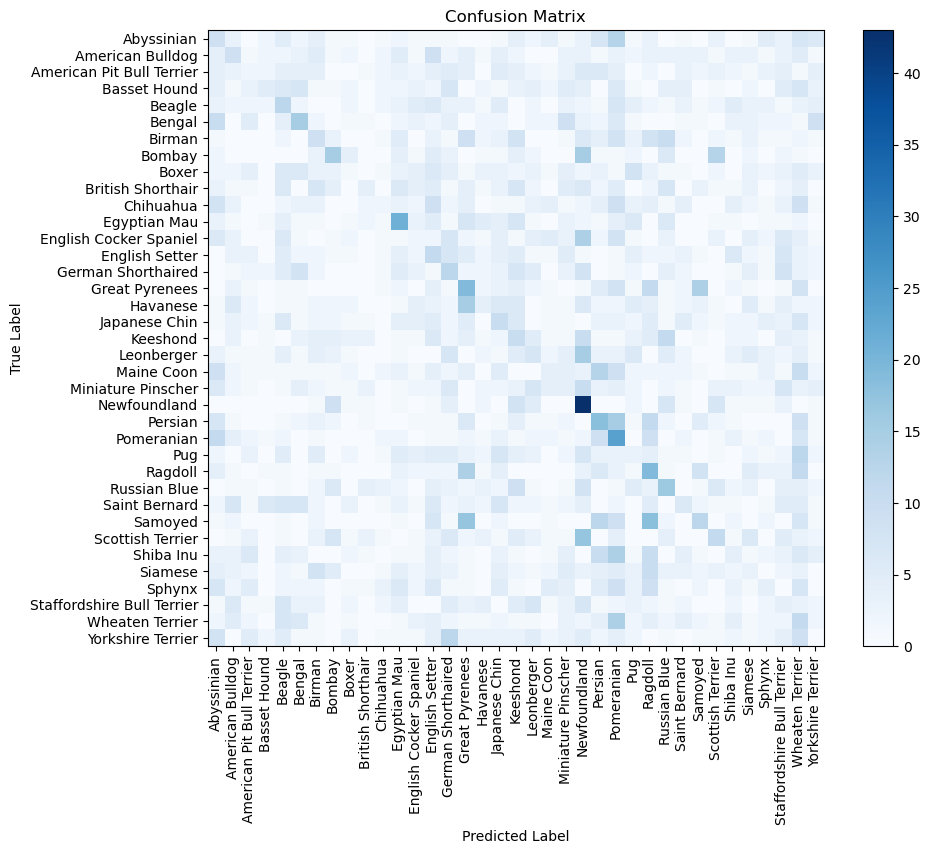

In [ ]:
# Testing 
# NOTE overfitting can be seen in the accuracy difference between train and test sets
train_labels, train_preds = evaluate_model(model, train_loader)
print(f"Accuracy on train set: {accuracy_score(train_labels, train_preds)}")

test_labels, test_preds = evaluate_model(model, test_loader)
print(f"Accuracy on test set: {accuracy_score(test_labels, test_preds)}")

# TODO add more metrics: confusion matrix, F1-score
print(f"Test f1-score: {f1_score(test_labels, test_preds, average='weighted')}")

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### More real use case: using a pretrained model

In [27]:
# Load pretrained ResNet18
resnet_model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1") # Model instantiation
resnet_model.fc = torch.nn.Linear(resnet_model.fc.in_features, num_classes) # Adapt last layer to current use case

# Display the architecture of the model
print(resnet_model)

ResNet(
  (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
  (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (relu): ReLU(inplace=True)
  (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
  (layer1): Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
  

Epoch 1/10, Train Loss: 2.0326 - Val Loss: 1.0900
Epoch 2/10, Train Loss: 0.8098 - Val Loss: 0.9237
Epoch 3/10, Train Loss: 0.3291 - Val Loss: 0.8062
Epoch 4/10, Train Loss: 0.1405 - Val Loss: 0.7921
Epoch 5/10, Train Loss: 0.0809 - Val Loss: 0.7871
Epoch 6/10, Train Loss: 0.0666 - Val Loss: 0.8086
Epoch 7/10, Train Loss: 0.0792 - Val Loss: 0.9873
Epoch 8/10, Train Loss: 0.0840 - Val Loss: 1.1352
Epoch 9/10, Train Loss: 0.1003 - Val Loss: 1.1396
Epoch 10/10, Train Loss: 0.0839 - Val Loss: 1.0233
Training complete


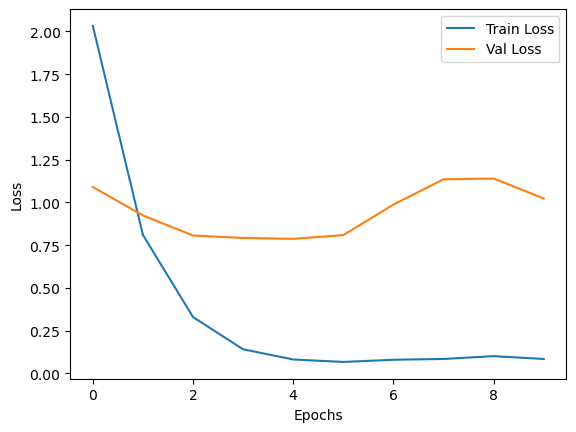

In [ ]:
# Training  # TODO change the learning rate, number of epochs, batch size and see the effect on performance
# NOTE using a pretrained resnet (trained on more data before) works better but still overfits a bit
# NOTE training resnet is computationally expensive and may take time depending on your hardware
criterion = torch.nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(resnet_model.parameters(), lr=1e-4, weight_decay=1e-4) # Optimizer
num_epochs = 10

train_losses, val_losses = list(), list()
for epoch in range(num_epochs):
    resnet_model.train() # training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    resnet_model.eval()  # evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = resnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}')
print('Training complete')

# Plot training and validation loss
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

Accuracy on train set: 0.9983016304347826
Accuracy on test set: 0.7421640774052876
Test f1-score: 0.7378763395622588


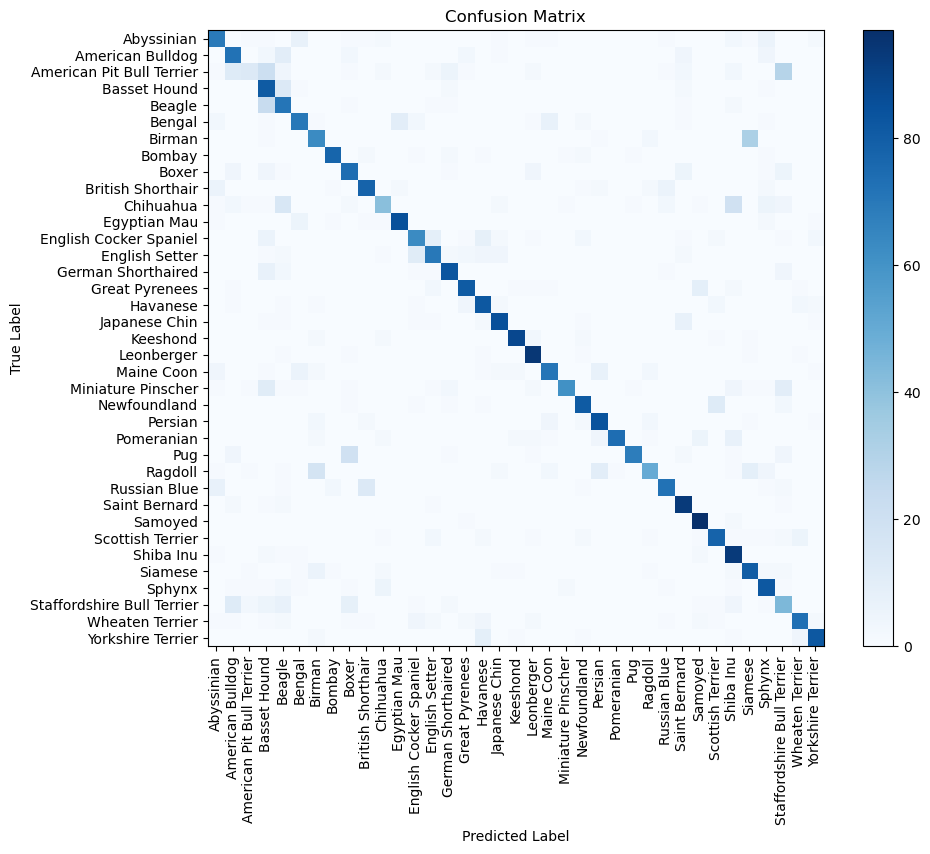

In [29]:
# TODO evaluate the ResNet model
train_labels, train_preds = evaluate_model(resnet_model, train_loader)
print(f"Accuracy on train set: {accuracy_score(train_labels, train_preds)}")

test_labels, test_preds = evaluate_model(resnet_model, test_loader)
print(f"Accuracy on test set: {accuracy_score(test_labels, test_preds)}")

# TODO add more metrics: confusion matrix, F1-score
print(f"Test f1-score: {f1_score(test_labels, test_preds, average='weighted')}")

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

In [ ]:
# TODO Try freezing all layers but the classifier head and retrain
# NOTE freezing layers is often beneficial when little data is available as it impedes memorization of the training set by the model in its trainable parameters
frozen_resnet_model = models.resnet18(weights="ResNet18_Weights.IMAGENET1K_V1") 
for param in frozen_resnet_model.parameters():
    param.requires_grad = False
    
frozen_resnet_model.fc = torch.nn.Linear(frozen_resnet_model.fc.in_features, num_classes)

In [ ]:
# Training  # TODO change the learning rate, number of epochs, batch size and see the effect on performance
criterion = torch.nn.CrossEntropyLoss() # Loss function
optimizer = torch.optim.AdamW(frozen_resnet_model.parameters(), lr=1e-4, weight_decay=1e-4) # Optimizer
num_epochs = 50

train_losses, val_losses = list(), list()
for epoch in range(num_epochs):
    frozen_resnet_model.train() # training mode
    running_loss = 0.0
    for inputs, labels in train_loader:
        optimizer.zero_grad()
        outputs = frozen_resnet_model(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()
        running_loss += loss.item()
    epoch_loss = running_loss / len(train_loader)
    train_losses.append(epoch_loss)

    frozen_resnet_model.eval()  # evaluation mode
    val_loss = 0.0
    with torch.no_grad():
        for inputs, labels in val_loader:
            outputs = frozen_resnet_model(inputs)
            loss = criterion(outputs, labels)
            val_loss += loss.item()
        val_loss /= len(val_loader)
        val_losses.append(val_loss)

    print(f'Epoch {epoch+1}/{num_epochs}, Train Loss: {epoch_loss:.4f} - Val Loss: {val_loss:.4f}')
print('Training complete')

# Plot training and validation loss
plt.plot(range(num_epochs), train_losses, label='Train Loss')
plt.plot(range(num_epochs), val_losses, label='Val Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()

Epoch 1/50, Train Loss: 3.5345 - Val Loss: 3.2400
Epoch 2/50, Train Loss: 3.0975 - Val Loss: 2.8648
Epoch 3/50, Train Loss: 2.7655 - Val Loss: 2.5075
Epoch 4/50, Train Loss: 2.4830 - Val Loss: 2.2394
Epoch 5/50, Train Loss: 2.2676 - Val Loss: 2.0193
Epoch 6/50, Train Loss: 2.0873 - Val Loss: 1.8664
Epoch 7/50, Train Loss: 1.9407 - Val Loss: 1.7359
Epoch 8/50, Train Loss: 1.8027 - Val Loss: 1.6421
Epoch 9/50, Train Loss: 1.7231 - Val Loss: 1.5761
Epoch 10/50, Train Loss: 1.6175 - Val Loss: 1.4824
Epoch 11/50, Train Loss: 1.5478 - Val Loss: 1.4191
Epoch 12/50, Train Loss: 1.4982 - Val Loss: 1.3922
Epoch 13/50, Train Loss: 1.4194 - Val Loss: 1.3333
Epoch 14/50, Train Loss: 1.3577 - Val Loss: 1.2744
Epoch 15/50, Train Loss: 1.3355 - Val Loss: 1.2632
Epoch 16/50, Train Loss: 1.2831 - Val Loss: 1.2301
Epoch 17/50, Train Loss: 1.2363 - Val Loss: 1.2070
Epoch 18/50, Train Loss: 1.2142 - Val Loss: 1.1935
Epoch 19/50, Train Loss: 1.1636 - Val Loss: 1.1749
Epoch 20/50, Train Loss: 1.1424 - Val Lo

Accuracy on train set: 0.9116847826086957
Accuracy on test set: 0.8509130553284273
Test f1-score: 0.8489641203628782


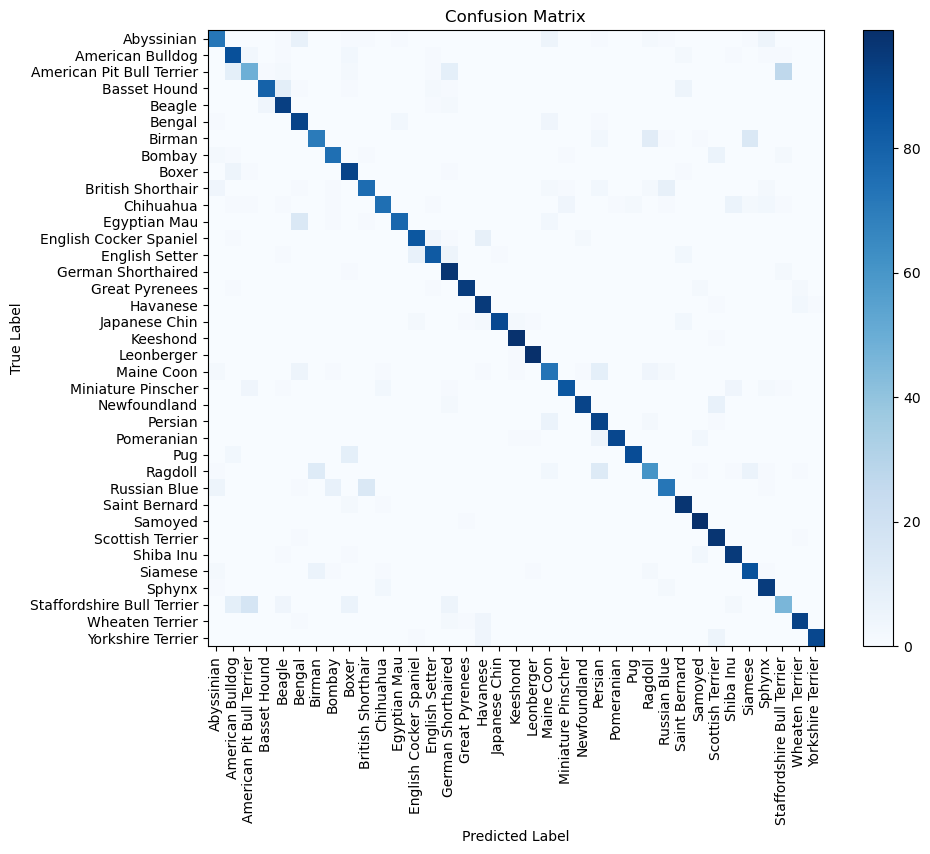

In [ ]:
# TODO evaluate the ResNet model
train_labels, train_preds = evaluate_model(frozen_resnet_model, train_loader)
print(f"Accuracy on train set: {accuracy_score(train_labels, train_preds)}")

test_labels, test_preds = evaluate_model(frozen_resnet_model, test_loader)
print(f"Accuracy on test set: {accuracy_score(test_labels, test_preds)}")

# TODO add more metrics: confusion matrix, F1-score
print(f"Test f1-score: {f1_score(test_labels, test_preds, average='weighted')}")

cm = confusion_matrix(test_labels, test_preds)
plt.figure(figsize=(10, 8))
plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Blues)
plt.title('Confusion Matrix')
plt.colorbar()
tick_marks = range(len(class_names))
plt.xticks(tick_marks, class_names, rotation=90)
plt.yticks(tick_marks, class_names)
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

#### So what is actually going on?

In [31]:
# TODO check the output of the first layer
for inputs, labels in val_loader:
    first_layer_output = frozen_resnet_model.conv1(inputs)
    print(first_layer_output.shape)
    break

torch.Size([8, 64, 112, 112])


### Doing image segmentation

Try doing it all yourself on an image segmentation task

In [ ]:
from torchvision import transforms
from torchvision.datasets import OxfordIIITPet
from torch.utils.data import DataLoader
import segmentation_models_pytorch as smp

# Standard ImageNet normalization values
IMAGE_NET_MEAN = [0.485, 0.456, 0.406]
IMAGE_NET_STD = [0.229, 0.224, 0.225]

def denormalize(img):
    """Denormalize an ImageNet image tensor for visualization."""
    mean = torch.tensor(IMAGE_NET_MEAN).view(3,1,1)
    std = torch.tensor(IMAGE_NET_STD).view(3,1,1)
    img = img * std + mean 
    img = img.permute(1,2,0) 
    img = img.clamp(0,1)
    return img

In [ ]:
# Transforms for images and masks
img_transform = transforms.Compose([
    transforms.Resize((128,128)),
    transforms.ToTensor(),
    transforms.Normalize(IMAGE_NET_MEAN, IMAGE_NET_STD)
])

mask_transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.PILToTensor(), 
])

# Load dataset (with masks)
dataset = OxfordIIITPet(
    root='./data', 
    download=True, 
    transform=img_transform, 
    target_types='segmentation'
)

def collate_fn(batch):
    images = torch.stack([item[0] for item in batch])
    masks = torch.stack([mask_transform(item[1]) for item in batch])
    return images, masks

loader = DataLoader(dataset, batch_size=4, shuffle=True, collate_fn=collate_fn)

# Load pretrained U-Net (encoder pretrained on ImageNet)
model = smp.Unet(encoder_name="resnet18", encoder_weights="imagenet", in_channels=3, classes=1)

In [ ]:
# Visualize some predictions
model.eval()

images, masks = next(iter(loader)) 
masks = masks.float() / masks.max() # Convert masks to 0/1 (background vs pet)
with torch.no_grad():
    images_resized = torch.nn.functional.interpolate(images, size=(128,128))
    outputs = model(images_resized)
    preds = torch.sigmoid(outputs)


fig, axes = plt.subplots(4, 3, figsize=(12, 12))
for i in range(4):
    axes[i,0].imshow(denormalize(images[i]))
    axes[i,0].set_title("Image")
    axes[i,0].axis('off')
    
    axes[i,1].imshow(masks[i][0], cmap='gray')
    axes[i,1].set_title("True Mask")
    axes[i,1].axis('off')
    
    axes[i,2].imshow(preds[i][0], cmap='gray')
    axes[i,2].set_title("Pred Mask")
    axes[i,2].axis('off')

plt.tight_layout()
plt.show()

In [ ]:
images, masks = next(iter(loader)) 

masks.bincount()